# Bundled electron insert factors modelling example

## Description
The code here provided is for the modelling of the portion of the electron output factor that is dependent on the shape of the shielding insert mounted within the applicator. This allows modelling insert factors using only the measured factors already available at a centre. Should all outliers be removed from the data set the user might expect as low as 0.5% standard uncertainty for factor prediction with as little as 8 data points.

The paper outlining this method is currently in press:
 
 > S. Biggs, M. Sobolewski, R. Murry, J. Kenny, Spline modelling electron insert factors using routine measurements. Physica Medica (2015), [doi:10.1016/j.ejmp.2015.11.002](http://dx.doi.org/10.1016/j.ejmp.2015.11.002). 

If you have any issues please don't hesitate to contact me (mail@simonbiggs.net), I likely will be more than happy to help. 

Any use of the code accepts the AGPL3+ license which includes no warranty that this code is fit for a particular purpose. Attempts have been made to make the code transparent and it is recommended that an experienced python programmer and physicist who understands the procedure outlined in the paper and the requirements of your centre identifies whether or not this method and code is fit for your use.


## Running this notebook
 * Download and install the relevant Anaconda Python 3.5 install from [continuum.io/downloads](https://www.continuum.io/downloads).
 * Run `install_required_modules.bat`
 * Open the shortcut `open_notebook` to boot the jupyter notebook server then open the `electroninserts_notebook.ipynb` file

### Importing all the packages to be used in this notebook

In [23]:
import dicom

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.io import output_notebook, output_file

# These functions are contained within electroninserts.py included with this notebook
from electroninserts import (
    parameterise_single_insert, display_parameterisation,
    create_report_from_pandas)

### Parameterising shapes

#### From coordinates

Width = 6.53 cm
Length = 10.99 cm


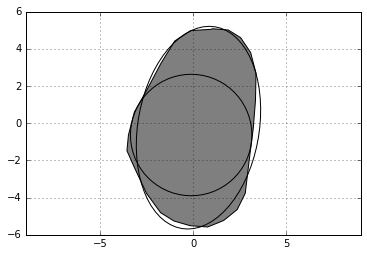

In [17]:
x = [0.99, -0.14, -1.0, -1.73, -2.56, -3.17, -3.49, -3.57, -3.17, -2.52, -1.76,
    -1.04, -0.17, 0.77, 1.63, 2.36, 2.79, 2.91, 3.04, 3.22, 3.34, 3.37, 3.08, 2.54,
    1.88, 1.02, 0.99]
y = [5.05, 4.98, 4.42, 3.24, 1.68, 0.6, -0.64, -1.48, -2.38, -3.77, -4.81,
    -5.26, -5.51, -5.58, -5.23, -4.64, -3.77, -2.77, -1.68, -0.29, 1.23, 2.68, 3.8,
    4.6, 5.01, 5.08, 5.05]

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm\nLength = {1:0.2f} cm".format(width, length))

display_parameterisation(x, y, width, length, poi)

#### From dicom

Width = 4.11 cm
Length = 9.52 cm


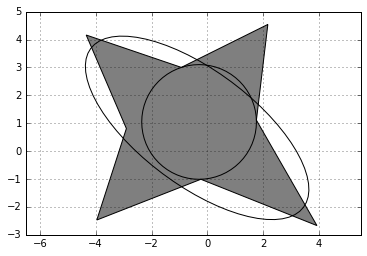

In [22]:
dicom_filename = "star.dcm"

dcm = dicom.read_file(dicom_filename, force=True)
block_data = np.array(dcm.BeamSequence[0].BlockSequence[0].BlockData)
x = np.array(block_data[0::2]).astype(float)/10
y = np.array(block_data[1::2]).astype(float)/10

width, length, poi = parameterise_single_insert(x, y)
print("Width = {0:0.2f} cm\nLength = {1:0.2f} cm".format(width, length))

display_parameterisation(x, y, width, length, poi)

#### From Monaco 5.10 tel file

In [ ]:
search_for_tel_file = 

In [ ]:
tel_filename

### Recording all the data

### Displaying a given applicator / energy / ssd combination

### Creating reports for all data with at least 8 data point

## Copyright information
Copyright &#169; 2015  Simon Biggs

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.